In [1]:
import torch 
from joblib import dump, load
import os
import random

print(torch.__version__)
print(torch.cuda.is_available())
import scatlasvae
import scanpy as sc


import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd # import pandas
import gc # import garbage collector
from typing import Literal, Union # import typing
#!nvidia-smi --query-gpu=name --format=csv,noheader

import time
import xlwt
import gseapy



/omics/odcf/analysis/hipo/hipo_021/Rhode/environments/3_8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1+cu117
True


In [2]:
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
def make_colormap( colors, show_palette = False ): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in colors ] )
    if show_palette:
        plt.figure( figsize = (15,3))
        plt.imshow( [ list(np.arange(0, len( colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
        plt.xticks([])
        plt.yticks([])
    return color_ramp

In [3]:
adata_cd8_zheng_2021_merged = sc.read_h5ad("/omics/odcf/analysis/hipo/hipo_021/Rhode/um/dataset_vae/scripts/integration_cd8_umap_06_02_2026_default_titan.h5ad")


In [4]:
def DEG_analysis(adata, groupby, query_subtype, reference_subtype, dw=True, disease=None):
    """
    Performs DEG analysis and GO enrichment.
    
    Parameters:
    -----------
    disease : str or list, optional
        If provided, filters QUERY cells to specific disease(s),
        but compares them against ALL reference cells (any disease).
    """
    
    if disease is not None:
        disease_col = 'disease_type'  # Change to your actual column name
        
        # Filter query subtype to specific disease(s)
        if isinstance(disease, str):
            query_mask = (adata.obs[groupby] == query_subtype) & (adata.obs[disease_col] == disease)
        elif isinstance(disease, list):
            query_mask = (adata.obs[groupby] == query_subtype) & (adata.obs[disease_col].isin(disease))
        else:
            raise ValueError("disease must be a string or list of strings")
        
        # Reference can be from ANY disease
        if reference_subtype == 'rest':
            reference_mask = adata.obs[groupby] != query_subtype
        else:
            reference_mask = adata.obs[groupby] == reference_subtype
        
        # Create temporary labels for comparison
        adata_subset = adata.copy()
        adata_subset.obs['temp_comparison'] = 'other'
        adata_subset.obs.loc[query_mask, 'temp_comparison'] = f'{query_subtype}_{disease}'
        adata_subset.obs.loc[reference_mask, 'temp_comparison'] = 'reference'
        
        # Keep only query disease cells + all reference cells
        adata_subset = adata_subset[query_mask | reference_mask].copy()
        
        print(f"Comparing {query_mask.sum()} {query_subtype} cells from {disease}")
        print(f"Against {reference_mask.sum()} reference cells (any disease)")
        
        # Update for rank_genes_groups
        groupby_use = 'temp_comparison'
        query_use = f'{query_subtype}_{disease}'
        reference_use = 'reference'
        
    else:
        adata_subset = adata
        groupby_use = groupby
        query_use = query_subtype
        reference_use = reference_subtype
    
    ## stats
    sc.tl.rank_genes_groups(
        adata_subset, 
        groupby=groupby_use, 
        method="t-test", 
        key_added='rank_genes_test',
        groups=[query_use], 
        reference=reference_use
    )
    
    diff_exp_genes = pd.DataFrame(np.hstack([
        np.array(list(map(list, adata_subset.uns["rank_genes_test"]["names"]))),
        np.array(list(map(list, adata_subset.uns["rank_genes_test"]['logfoldchanges']))),
        np.array(list(map(list, adata_subset.uns["rank_genes_test"]['pvals_adj'])))
    ]),
            columns = list(range(3))
    )
    
    diff_exp_genes_up = diff_exp_genes[(~diff_exp_genes[0].isin(blacklist)) &
                                        (diff_exp_genes[1].astype('float')>=0.25) &
                                        (diff_exp_genes[2].astype('float')<=0.05)]
    diff_exp_genes_dw = diff_exp_genes[(~diff_exp_genes[0].isin(blacklist)) &
                                        (diff_exp_genes[1].astype('float')<=-0.25) &
                                        (diff_exp_genes[2].astype('float')<=0.05)]
    
    # Read GMT file as text and convert to dictionary
    gene_sets_dict = {}
    with open('/omics/odcf/analysis/hipo/hipo_021/Rhode/um/dataset_vae/DS_files_7825/GO_Biological_Process_2025.txt', 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                term_name = parts[0]
                genes = parts[2:]
                gene_sets_dict[term_name] = genes
    
    def enr_res(adata=adata_subset, 
                groupby=groupby_use,
                diff_exp_genes=diff_exp_genes_up,
                subtype=query_use):
        ht = sc.pl.dotplot(
            adata,
            diff_exp_genes.iloc[:,0],
            groupby=groupby, 
            show=False, 
            return_fig=True
        )
        size_df = ht.dot_size_df

        s = set(size_df.loc[subtype,size_df.loc[subtype] > 0.25].index)
        enr_res_df = pd.DataFrame(list(filter(lambda x: x in s, diff_exp_genes.iloc[:,0])))
        
        import gseapy as gp
        enr_res_use = gp.enrich(
            gene_list=enr_res_df.iloc[:,0],
            gene_sets=gene_sets_dict,
            outdir=None,
            no_plot=True,
            verbose=False
        )
        return enr_res_use
    
    enr_res_up = enr_res(diff_exp_genes=diff_exp_genes_up, subtype=query_use)
    if dw==True:
        enr_res_dw = enr_res(diff_exp_genes=diff_exp_genes_dw, subtype=reference_use)
    else:
        enr_res_dw = enr_res_up
    
    return diff_exp_genes,diff_exp_genes_up,diff_exp_genes_dw,enr_res_up,enr_res_dw


In [5]:
blacklist = ["ACTG1","BTG1","CXCL1","DNAJB4","ERRFI1","H3F3B","HSPB1","IRF1","KLF6","MIR22HG","NFKBIA","PCF11","PXDC1","SDC4","SRF",
             "TPM3","USP2","GADD45G","ANKRD1","BTG2","CYR61","DUSP1","FAM132B","HIPK3","HSPH1","IRF8","KLF9","MT1","NFKBIZ","PDE4B",
             "RAP1B","SERPINE1","SRSF5","TPPP3","WAC","HSPE1","ARID5A","CCNL1","DCN","DUSP8","FOS","HSP90AA1","ID3","ITPKC","LITAF",
             "MT2","NOP58","PER1","RASSF1","SKIL","SRSF7","TRA2A","ZC3H12A","IER5","ATF3","CCRN4L","DDX3X","EGR1","FOSB","HSP90AB1",
             "IDI1","JUN","LMNA","MYADM","NPPC","PHLDA1","RHOB","SLC10A6","STAT3","TRA2B","ZFAND5","KCNE4","ATF4","CEBPB","DDX5","EGR2",
             "FOSL2","HSPA1A","IER2","JUNB","MAFF","MYC","NR4A1","PNP","RHOH","SLC38A2","TAGLN2","TRIB1","ZFP36","BAG3","CEBPD","DES","EIF1",
             "GADD45A","HSPA1B","IER3","JUND","MAFK","MYD88","ODC1","PNRC1","RIPK1","SLC41A1","TIPARP","TUBB4B","ZFP36L1","BHLHE40","CEBPG","DNAJA1",
             "EIF5","GCC1","HSPA5","IFRD1","KLF2","MCL1","NCKAP5L","OSGIN1","PPP1CC","SAT1","SOCS3","TNFAIP3","TUBB6","ZFP36L2","BRD2","CSRNP1","DNAJB1",
             "ERF","GEM","HSPA8","IL6","KLF4","MIDN","NCOA7","OXNAD1","PPP1R15A","SBNO2","SQSTM1","TNFAIP6","UBC","ZYX"]



sc.pp.normalize_total(adata_cd8_zheng_2021_merged, target_sum=1e4)
sc.pp.log1p(adata_cd8_zheng_2021_merged)

adata_cd8_zheng_2021_merged.uns['log1p']['base'] = None   # tells Scanpy to use log1p transform

In [ ]:
adata_cd8_zheng_2021_merged.obs['cell_subtype_3_prediction'].unique()

In [16]:
# Filter for UM and count by cell type
counts = adata_cd8_zheng_2021_merged[
    adata_cd8_zheng_2021_merged.obs['disease_type'] == "UM"
].obs['cell_subtype_3_prediction'].value_counts()

print(counts)



GZMK+ Tex        25145
CREM+ Trm        10935
Early Tcm/Tem     9122
MAIT              5239
ITGAE+ Trm        4354
Cycling T         4199
ILTCK             3923
ITGAE+ Tex        3573
ITGB2+ Trm        2351
MACF1+ T          2268
CMC1+ Temra       1796
GNLY+ Temra       1471
GZMK+ Tem         1453
XBP1+ Tex          981
Tpex               473
ZNF683+ Teff       176
Tcm                172
Tn                  98
Name: cell_subtype_3_prediction, dtype: int64


In [7]:
cycling_T_cells = DEG_analysis(adata_cd8_zheng_2021_merged, groupby='cell_subtype_3_prediction',
                       query_subtype='Cycling T', reference_subtype='rest', dw=True, disease="UM")


Comparing 4199 Cycling T cells from UM
Against 1148190 reference cells (any disease)


(              0           1    2
 0         STMN1    5.548732  0.0
 1         HMGB2    4.408209  0.0
 2        TUBA1B   4.0308886  0.0
 3          TUBB    4.083977  0.0
 4         MKI67    8.129389  0.0
 ...         ...         ...  ...
 3843     S100A8  -26.399345  0.0
 3844  MTRNR2L12  -6.2331343  0.0
 3845        LYZ  -26.655497  0.0
 3846    TMEM173  -5.9242682  0.0
 3847       H1FX   -5.897255  0.0
 
 [3848 rows x 3 columns],
             0          1                     2
 0       STMN1   5.548732                   0.0
 1       HMGB2   4.408209                   0.0
 2      TUBA1B  4.0308886                   0.0
 3        TUBB   4.083977                   0.0
 4       MKI67   8.129389                   0.0
 ...       ...        ...                   ...
 2556      GAL  3.6510482  0.048444389585697675
 2557  C1QTNF1  2.0864878   0.04855495538853593
 2558      GIP  3.6509163  0.048959566748252754
 2559    PADI3  3.8671439   0.04973424336244741
 2560    DPEP1  2.6521802   0.049874

In [23]:
GMZK = DEG_analysis(adata_cd8_zheng_2021_merged, groupby='cell_subtype_3_prediction',
                       query_subtype='ITGAE+ Trm', reference_subtype='rest', dw=True, disease="UM")

GMZK 

Comparing 4354 ITGAE+ Trm cells from UM
Against 1105245 reference cells (any disease)


(              0           1    2
 0         ZFP36   3.6501236  0.0
 1          RGCC    5.249385  0.0
 2       TNFAIP3   3.1719646  0.0
 3         CXCR4    2.640405  0.0
 4          CREM   4.0862775  0.0
 ...         ...         ...  ...
 3843  HIST1H2AL  -25.883268  0.0
 3844     S100A8  -26.457302  0.0
 3845   HIST1H1D  -5.8185706  0.0
 3846        LYZ  -26.671026  0.0
 3847   HIST1H1E  -6.3549843  0.0
 
 [3848 rows x 3 columns],
          0          1                     2
 1     RGCC   5.249385                   0.0
 3    CXCR4   2.640405                   0.0
 4     CREM  4.0862775                   0.0
 5    NR4A2  3.5210745                   0.0
 10   ANXA1  2.7705595                   0.0
 ..     ...        ...                   ...
 936  PEX5L  1.4609402  0.046563542435076447
 938   RAI2  1.1326807  0.049014309705929446
 939  EPHA3  1.4350203    0.0493878410044759
 940   DOK5  1.5701065  0.049672059097339065
 941  HTR2A  2.7231984  0.049853613460875246
 
 [835 rows x 3 columns

In [8]:
def plot_enrichment_results(deg_results, output_file='figures/GO_enrichment.pdf', 
                           top_n=50, pval_cutoff=0.05, figsize=(8, 5)):
    """
    Plot GO enrichment for upregulated and downregulated genes side by side.
    
    Parameters:
    -----------
    deg_results : tuple
        Output from DEG_analysis: (diff_exp_genes, diff_exp_genes_up, diff_exp_genes_dw, 
                                   enr_res_up, enr_res_dw, adata_subset)
    output_file : str
        Path to save the figure
    top_n : int
        Number of top terms to show
    pval_cutoff : float
        Adjusted p-value cutoff
    figsize : tuple
        Figure size for each subplot
    """
    from matplotlib.colors import LinearSegmentedColormap
    
    def make_colormap(colors):
        return LinearSegmentedColormap.from_list('custom', colors)
    
    # Extract enrichment results
    enr_res_up = deg_results[3]
    enr_res_dw = deg_results[4]
    
    # Check if upregulated enrichment is valid
    if hasattr(enr_res_up, 'res2d') and len(enr_res_up.res2d) > 0:
        # Filter upregulated
        up_sig = enr_res_up.res2d[enr_res_up.res2d['Adjusted P-value'] < pval_cutoff]
        up_sig = up_sig.drop_duplicates(['Term'], keep='first')
        up_sig = up_sig[0:top_n]
        
        # Clean Term names
        up_sig['Term'] = up_sig['Term'].str.split(" \(GO").str[0]
        
        print(f"Found {len(up_sig)} significant upregulated GO terms")
    else:
        up_sig = None
        print("No upregulated enrichment results")
    
    # Check if downregulated enrichment is valid
    if hasattr(enr_res_dw, 'res2d') and len(enr_res_dw.res2d) > 0:
        # Filter downregulated
        dw_sig = enr_res_dw.res2d[enr_res_dw.res2d['Adjusted P-value'] < pval_cutoff]
        dw_sig = dw_sig.drop_duplicates(['Term'], keep='first')
        dw_sig = dw_sig[0:top_n]
        
        # Clean Term names
        dw_sig['Term'] = dw_sig['Term'].str.split(" \(GO").str[0]
        
        print(f"Found {len(dw_sig)} significant downregulated GO terms")
    else:
        dw_sig = None
        print("No downregulated enrichment results")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(figsize[0]*2, figsize[1]))
    
    # Plot upregulated
    if up_sig is not None and len(up_sig) > 0:
        gseapy.dotplot(
            up_sig,  # Top 20 terms
            size=10,
            cmap=make_colormap(['#c8bad8', '#5f0caf']),
            ax=axes[0],
            title='Upregulated',
            vmin=1.3
        )
    else:
        axes[0].text(0.5, 0.5, 'No significant\nupregulated terms', 
                    ha='center', va='center', fontsize=12)
        axes[0].set_title('Upregulated')
        axes[0].axis('off')
    
    # Plot downregulated
    if dw_sig is not None and len(dw_sig) > 0:
        gseapy.dotplot(
            dw_sig,  # Top 20 terms
            size=10,
            cmap=make_colormap(['#ffd8a8', '#fd7e14']),
            ax=axes[1],
            title='Downregulated',
            vmin=1.3
        )
    else:
        axes[1].text(0.5, 0.5, 'No significant\ndownregulated terms', 
                    ha='center', va='center', fontsize=12)
        axes[1].set_title('Downregulated')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.savefig(output_file.replace('.pdf', '.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return up_sig, dw_sig


def plot_single_enrichment(enr_result, title='GO Enrichment', output_file=None,
                          top_n=50, pval_cutoff=0.05, figsize=(4, 6), 
                          cmap_colors=['#c8bad8', '#5f0caf']):
    """
    Plot a single GO enrichment result.
    
    Parameters:
    -----------
    enr_result : GSEApy enrichment object
        The enrichment result (enr_res_up or enr_res_dw)
    title : str
        Title for the plot
    output_file : str, optional
        Path to save the figure
    top_n : int
        Number of top terms to show
    pval_cutoff : float
        Adjusted p-value cutoff
    figsize : tuple
        Figure size
    cmap_colors : list
        Two colors for the colormap
    """
    from matplotlib.colors import LinearSegmentedColormap
    
    def make_colormap(colors):
        return LinearSegmentedColormap.from_list('custom', colors)
    
    if not hasattr(enr_result, 'res2d') or len(enr_result.res2d) == 0:
        print(f"No enrichment results for {title}")
        return None
    
    # Filter and prepare data
    sig_terms = enr_result.res2d[enr_result.res2d['Adjusted P-value'] < pval_cutoff]
    sig_terms = sig_terms.drop_duplicates(['Term'], keep='first')
    sig_terms = sig_terms[0:top_n]
    
    # Clean Term names
    sig_terms['Term'] = sig_terms['Term'].str.split(" \(GO").str[0]
    
    print(f"Found {len(sig_terms)} significant GO terms for {title}")
    
    if len(sig_terms) == 0:
        print(f"No significant terms after filtering for {title}")
        return None
    
    # Plot
    fig = plt.figure(figsize=figsize)
    gseapy.dotplot(
        sig_terms.iloc[0:min(20, len(sig_terms)), :],  # Top 20 or fewer
        size=10,
        cmap=make_colormap(cmap_colors),
        title=title,
        figsize=figsize,
        vmin=1.3
    )
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.savefig(output_file.replace('.pdf', '.png'), dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return sig_terms


Found 29 significant upregulated GO terms
Found 50 significant downregulated GO terms


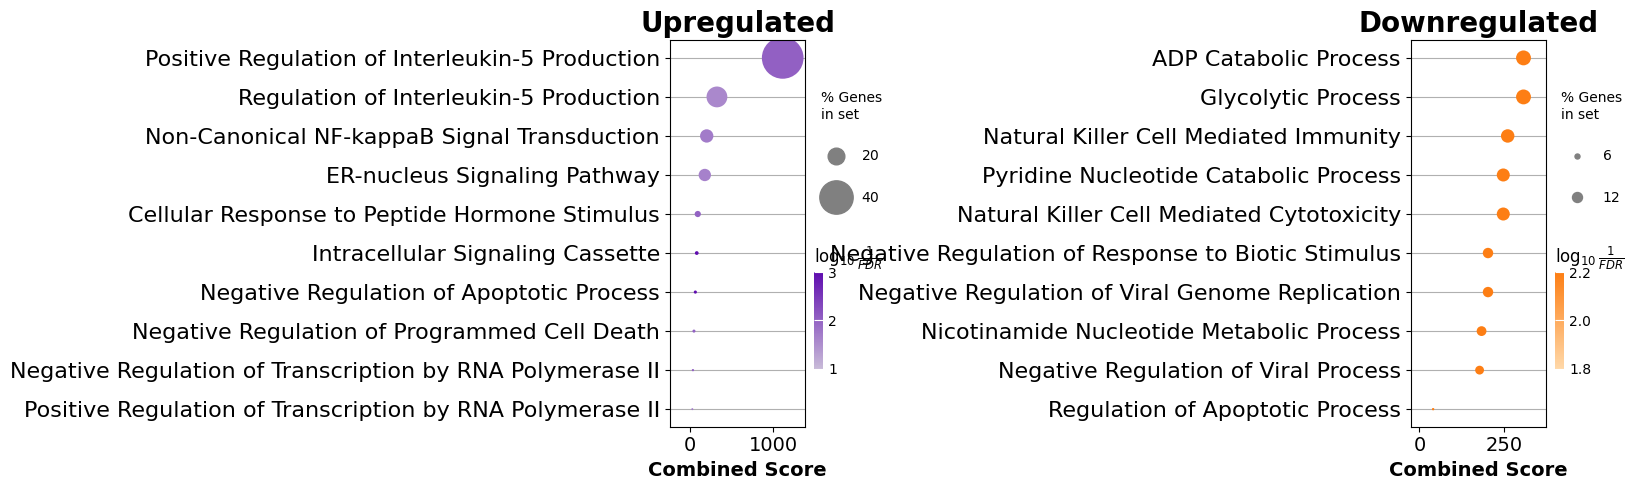

(      Gene_set                                               Term  Overlap  \
 63    gs_ind_0            Canonical NF-kappaB Signal Transduction     4/36   
 108   gs_ind_0             Cellular Response to Cytokine Stimulus   10/289   
 147   gs_ind_0    Cellular Response to Oxygen-Containing Compound   12/384   
 148   gs_ind_0      Cellular Response to Peptide Hormone Stimulus     7/94   
 188   gs_ind_0     Cytoskeleton-Dependent Intracellular Transport     3/17   
 203   gs_ind_0                          Dendritic Cell Chemotaxis     3/15   
 205   gs_ind_0                           Dendritic Cell Migration     3/18   
 219   gs_ind_0                       ER-nucleus Signaling Pathway     4/27   
 232   gs_ind_0                               Endoderm Development     3/14   
 319   gs_ind_0                              Inflammatory Response   10/261   
 339   gs_ind_0                   Intracellular Signaling Cassette   16/354   
 420   gs_ind_0                Mitotic Cell Cycle Ph

In [24]:

# Now plot
plot_enrichment_results(
    GMZK,
    output_file='GZMK+_Tex_GO_enrichment.pdf'
)


Found 50 significant upregulated GO terms
Found 40 significant downregulated GO terms


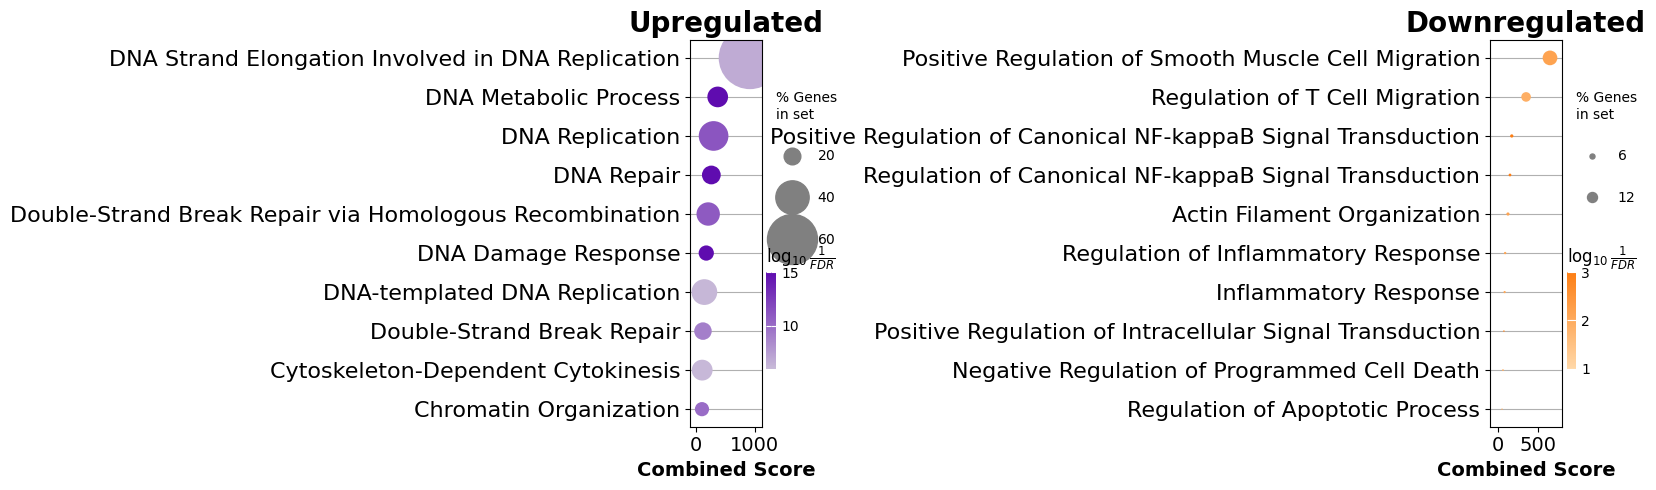

   Gene_set                                               Term Overlap  \
0  gs_ind_0  + Reg of Blood Vessel Endothelial Cell Prolife...     1/8   
1  gs_ind_0  + Reg of CD4-+, CD25-+, Alpha-Beta Regulatory ...     1/5   
2  gs_ind_0  + Reg of Endoplasmic Reticulum Stress-Induced ...     1/7   
3  gs_ind_0  + Reg of Myeloid Leukocyte Cytokine Production...    1/16   
4  gs_ind_0  + Reg of Natural Killer Cell Mediated Cytotoxi...     1/5   

    P-value  Adjusted P-value  Odds Ratio  Combined Score     Genes  
0  0.115328          0.326260   12.983820       28.044731  PPP1R16B  
1  0.073720          0.304688   21.644195       56.436878      IFNG  
2  0.101670          0.320484   14.982368       34.250101    PMAIP1  
3  0.217408          0.382051    6.279014        9.581643      CD74  
4  0.073720          0.304688   21.644195       56.436878     CRTAM  


In [63]:
# Now plot
plot_enrichment_results(
    cycling_T_cells ,
    output_file='cycling_GO_enrichment.pdf'
)

